In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mplcyberpunk as mplnk

In [2]:
import tensorflow as tf
import keras
from keras import Model, layers

2024-06-29 22:00:34.646626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 22:00:34.658328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 22:00:34.675698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 22:00:34.675735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-29 22:00:34.688498: I tensorflow/core/platform/cpu_feature_gua

In [3]:
from config import Config
from utils import DataLoader
from models import DeepMF
from models.layers import MinMaxNormalization

In [4]:
def build_generator():
    noise_dim = 100
    latent_dim = 5
    
    inputs = layers.Input(shape=(noise_dim,), name='gen_input')
    x = layers.Dense(units=10, name='dense_1')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_1')(x)
    x = layers.BatchNormalization(momentum=0.8, name='batch_norm')(x)
    x = layers.Dense(20, name='dense_2')(x)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_2')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    outputs = layers.Dense(units=latent_dim * 2 + 1, name='dense3')(x)
    
    return Model(inputs=inputs, outputs=outputs, name='generator')

def build_discriminator():
    latent_dim = 5
    
    inputs = layers.Input(shape=(latent_dim * 2 + 1,), name='disc_input')
    x = layers.Dense(units=4, name='dense4')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu1')(x)
    x = layers.Dense(units=1, name='dense5')(x)
    x = layers.Activation('sigmoid', name='sigmoid')(x)

    return Model(inputs=inputs, outputs=x, name='discriminator')

In [7]:

from pipe.pipeline import TrainingPipeline
from pipe import Trainer, Transform
from func import run_deepmf, run_gan

deepmf = Transform(
    name='deepmf',
    run_fn=run_deepmf,
    params={
        'epochs': 10,
        'batch_size': 32,
        'validation_freq': 3
    }
)

gan = Trainer(
    name='gan',
    run_fn=run_gan,
    params={
        'epochs': 30,
        'batch_size': 32,
        'noise_dim': 100,
        'generator': build_generator(),
        'discriminator': build_discriminator()
    }
)

pipeline = TrainingPipeline(
    train_set=DataLoader.load_numpy()[:2],
    val_set=DataLoader.load_numpy()[2:],
    components=[
        deepmf,
        gan
    ],
    resume=True
)

pipeline.get_component('gan')._ran

True

In [5]:
STD_DEV = 1.5 # You can stablish the fake samples variability by setting this value
noise = np.random.normal(0, STD_DEV, (50000, 100))

In [6]:
gen_data = pipeline.infer(noise)

NameError: name 'pipeline' is not defined

In [8]:
gen_data[:, -1] = MinMaxNormalization(min_val=0, max_val=5)(gen_data[:, -1]).numpy()

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [7]:
gan = keras.models.load_model(Config.Paths.REGISTRY_PATH.joinpath('gan.keras'), compile=True)

2024-06-29 17:17:05.769658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 17:17:05.810014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 17:17:05.810184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

KeyError: 'class_name'

In [18]:
gen_data = gan.predict(noise).numpy()

In [19]:
gen_data[:, -1] = MinMaxNormalization(min_val=0, max_val=5)(gen_data[:, -1]).numpy()

In [20]:
gen_data

array([[-9.061792  ,  2.9604473 , -4.40579   , ...,  2.0674753 ,
         1.1013422 ,  1.3882006 ],
       [-9.217667  ,  2.982888  , -4.3641424 , ...,  2.5260642 ,
         1.0886183 ,  2.2084162 ],
       [-8.896546  ,  2.6955996 , -3.568869  , ...,  2.181765  ,
         0.89123124,  1.7055979 ],
       ...,
       [-9.240618  ,  2.6341112 , -3.3408842 , ...,  2.215017  ,
         0.872881  ,  2.201088  ],
       [-8.843365  ,  2.7246308 , -3.684329  , ...,  2.3601704 ,
         0.9397934 ,  2.0147443 ],
       [-8.862244  ,  2.6569436 , -3.4088602 , ...,  2.285503  ,
         0.8033038 ,  1.8684433 ]], dtype=float32)

In [ ]:
df = DataLoader().load_train_data()

In [ ]:
plt.style.use('cyberpunk')

In [ ]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 5))

    value_counts = df['rating'].value_counts()
    bars = plt.bar(x=value_counts.index, height=value_counts.values)
    percantages = value_counts / value_counts.sum() * 100

    font_dict = {
        'fontweight': 'normal',
        'fontfamily': 'sans-serif',
        'fontsize': 10,
        'color': 'white'
    }

    for bar, percantage in zip(bars, percantages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percantage:.2f}%', ha='center', va='bottom', fontdict=font_dict)

    mplnk.add_bar_gradient(bars)

    plt.xlabel('Rating', fontweight='bold')
    plt.show()

In [ ]:
from utils.data_loader import DataLoader

In [ ]:
df = DataLoader().load_train_data()

In [ ]:
df.rename(columns={
    'user_id': 'user',
    'item_id': 'item'
}, inplace=True)

In [ ]:
df

user  item  rating
0       716   836       4
1       620   422       1
2       547   289       3
3       758   385       4
4       627   197       5
...     ...   ...     ...
79995   336   628       3
79996   749   637       1
79997   758   313       4
79998   380   139       1
79999   231   151       1

[80000 rows x 3 columns]

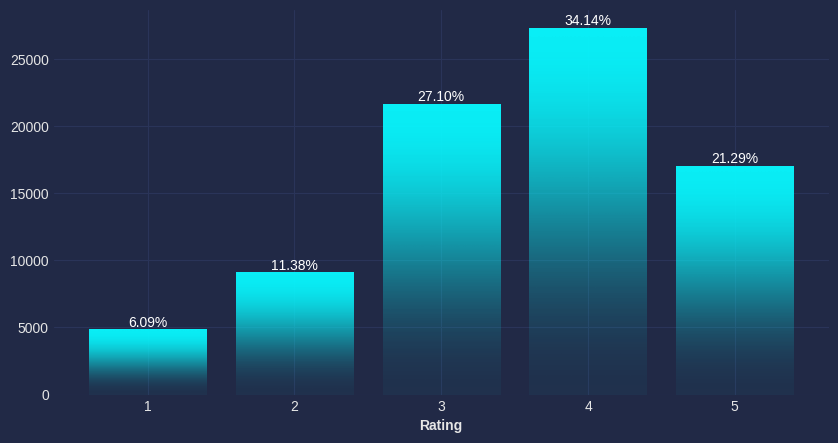

In [ ]:
plot_ratings_distribution(df)

In [ ]:
synth_df = pd.read_csv('../gen/synthetic_50000_500_1000.txt')

In [ ]:
synth_df = synth_df.astype({'rating': 'int32'})

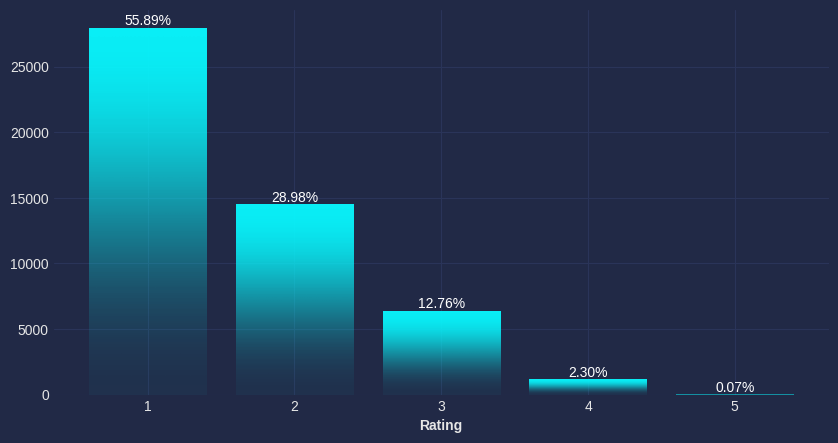

In [ ]:
plot_ratings_distribution(synth_df)

In [ ]:
synth_df

user  item  rating
0       186    60       1
1       424   947       1
2        29   185       3
3       207   911       1
4       277   302       4
...     ...   ...     ...
49995   133    95       2
49996   313   780       1
49997    25    46       1
49998   400   550       2
49999   350   584       1

[50000 rows x 3 columns]

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import f

class MANOVAMetric(metrics.Metric):
    def __init__(self, name='manova_metric', **kwargs):
        super(MANOVAMetric, self).__init__(name=name, **kwargs)
        self.real_data = []
        self.synthetic_data = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.real_data.append(y_true)
        self.synthetic_data.append(y_pred)

    def result(self):
        real_data = pd.concat(self.real_data, ignore_index=True)
        synthetic_data = pd.concat(self.synthetic_data, ignore_index=True)

        assert 'user' in real_data.columns and 'item' in real_data.columns and 'rating' in real_data.columns, \
            "Real data must contain 'user', 'item', and 'rating' columns"
        assert 'user' in synthetic_data.columns and 'item' in synthetic_data.columns and 'rating' in synthetic_data.columns, \
            "Synthetic data must contain 'user', 'item', and 'rating' columns"

        real_data = real_data.groupby(['user', 'item'], as_index=False).rating.mean()
        synthetic_data = synthetic_data.groupby(['user', 'item'], as_index=False).rating.mean()

        real_matrix = real_data.pivot(index='user', columns='item', values='rating').fillna(0)
        synthetic_matrix = synthetic_data.pivot(index='user', columns='item', values='rating').fillna(0)

        common_items = real_matrix.columns.intersection(synthetic_matrix.columns)
        real_matrix = real_matrix[common_items]
        synthetic_matrix = synthetic_matrix[common_items]

        # Check for identical data
        if real_matrix.equals(synthetic_matrix):
            return 1.0

        mean_real = real_matrix.mean(axis=0)
        mean_synthetic = synthetic_matrix.mean(axis=0)

        overall_mean = pd.concat([real_matrix, synthetic_matrix]).mean(axis=0)

        n_real = real_matrix.shape[0]
        n_synthetic = synthetic_matrix.shape[0]

        SS_between = n_real * np.outer(mean_real - overall_mean, mean_real - overall_mean) + \
                     n_synthetic * np.outer(mean_synthetic - overall_mean, mean_synthetic - overall_mean)

        SS_within_real = (real_matrix - mean_real).T @ (real_matrix - mean_real)
        SS_within_synthetic = (synthetic_matrix - mean_synthetic).T @ (synthetic_matrix - mean_synthetic)
        SS_within = SS_within_real + SS_within_synthetic

        # Use pseudo-inverse for numerical stability
        W_inv = np.linalg.pinv(SS_within)
        T2 = np.trace(np.dot(W_inv, SS_between))

        p = real_matrix.shape[1]
        df1 = p
        df2 = n_real + n_synthetic - p - 1
        F = (T2 * df2) / (df1 * (n_real + n_synthetic - df1 - 1))

        p_value = 1 - f.cdf(F, df1, df2)

        # Print intermediate results for diagnostics
        print(f"Mean Real: {mean_real}")
        print(f"Mean Synthetic: {mean_synthetic}")
        print(f"Overall Mean: {overall_mean}")
        print(f"SS Between: {SS_between}")
        print(f"SS Within: {SS_within}")
        print(f"T2: {T2}")
        print(f"F: {F}")
        print(f"p-value: {p_value}")

        return p_value

    def reset_states(self):
        self.real_data = []
        self.synthetic_data = []


In [ ]:
manova = MANOVAMetric()
manova.update_state(df, synth_df)

In [ ]:
manova.result()

Mean Real: item
1      1.500530
2      0.366914
3      0.199364
4      0.641569
5      0.259809
         ...   
995    0.080594
996    0.030753
997    0.022269
998    0.032874
999    0.022269
Length: 998, dtype: float64
Mean Synthetic: item
1      0.034595
2      0.042095
3      0.038333
4      0.064000
5      0.010000
         ...   
995    0.024600
996    0.018000
997    0.026000
998    0.040000
999    0.036000
Length: 998, dtype: float64
Overall Mean: item
1      0.992583
2      0.254364
3      0.143567
4      0.441441
5      0.173250
         ...   
995    0.061192
996    0.026334
997    0.023562
998    0.035343
999    0.027027
Length: 998, dtype: float64
SS Between: [[ 7.02174065e+02  1.55586289e+02  7.71325955e+01 ... -1.78695748e+00
  -3.41340371e+00 -6.57689750e+00]
 [ 1.55586289e+02  3.44744906e+01  1.70908822e+01 ... -3.95950371e-01
  -7.56334989e-01 -1.45729545e+00]
 [ 7.71325955e+01  1.70908822e+01  8.47288099e+00 ... -1.96294160e-01
  -3.74956439e-01 -7.22460711e-01]
 ...


1.0